In [58]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from utils.dataset import load_dataset_v2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error


In [2]:
file_name_list = os.listdir(os.path.join('data', 'ver_2'))
file_path_list = []

for file_name in file_name_list:
    file_path_list.append(os.path.join('data', 'ver_2', file_name))

dataset= load_dataset_v2(file_path_list)
dataset = dataset[dataset['outlet_flowrate(lpm)'] > 1]
dataset.reset_index(drop=True, inplace=True)

dataset = dataset[::10]
dataset.reset_index(drop=True, inplace=True)

feature_col_name_list = ['pressure_1(bar)', 'main_pressure(bar)']
target_col_name = 'outlet_flowrate(lpm)'

train_data = dataset[dataset['test_case_iter']!=3]
val_data = dataset[dataset['test_case_iter']==3]

train_data = train_data[feature_col_name_list + [target_col_name]]
val_data = val_data[feature_col_name_list + [target_col_name]]

train_feature = train_data[feature_col_name_list]
train_feature.reset_index(drop=True, inplace=True)

train_target = pd.DataFrame(train_data[target_col_name])
train_target.reset_index(drop=True, inplace=True)

val_feature = val_data[feature_col_name_list]
val_feature.reset_index(drop=True, inplace=True)

val_target = pd.DataFrame(val_data[target_col_name])
val_target.reset_index(drop=True, inplace=True)


loading dataset...:   0%|          | 0/84 [00:00<?, ?it/s]

In [74]:
linear_model = LinearRegression()
linear_model.fit(train_feature, train_target)
linear_model_pred = np.squeeze(linear_model.predict(val_feature))

print(linear_model.coef_)
print(linear_model.intercept_)

[[-547.34979877   67.07651071]]
[518.08007565]


In [24]:
val_target_arr = np.squeeze(val_target.to_numpy())
print(r2_score(val_target, linear_model_pred), mean_absolute_error(val_target, linear_model_pred), mean_absolute_percentage_error(val_target, linear_model_pred))

0.7109321152550396 206.92247862675737 1.3642786707511811


Text(0, 0.5, 'Predicted Outlet Flowrate (lpm)')

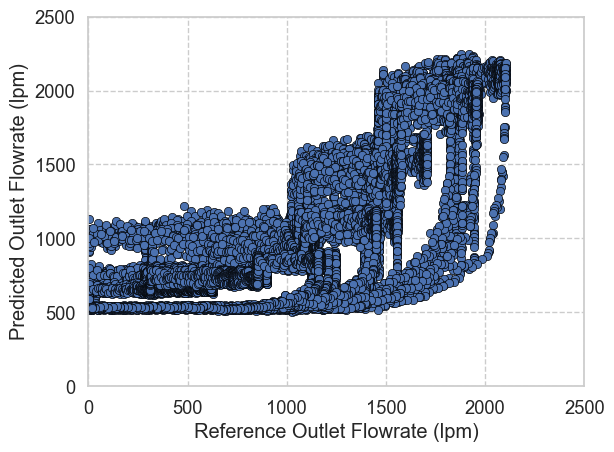

In [30]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=val_target_arr, y=linear_model_pred, edgecolor='black')

plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.xlabel('Reference Outlet Flowrate (lpm)')
plt.ylabel('Predicted Outlet Flowrate (lpm)')

Text(0.5, 0, 'Relative Error(%)')

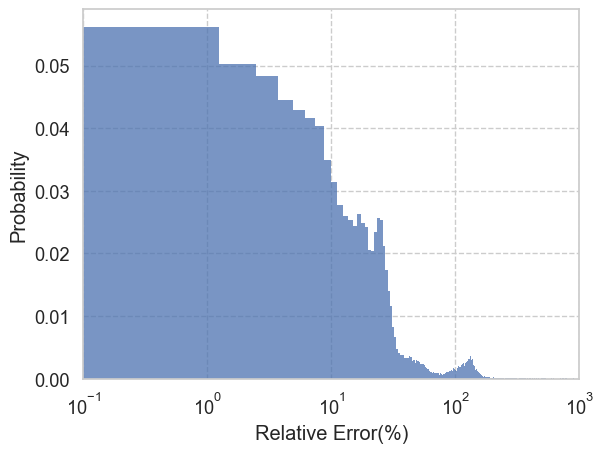

In [53]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

linear_model_abs_error = np.abs(val_target_arr - linear_model_pred)
linear_model_rel_error = linear_model_abs_error/val_target_arr*100

sns.histplot(linear_model_rel_error, stat='probability')

plt.xscale('log')
plt.xlim(0.1 , 1000)
plt.xlabel('Relative Error(%)')

Text(0.5, 0, 'Relative Error(%)')

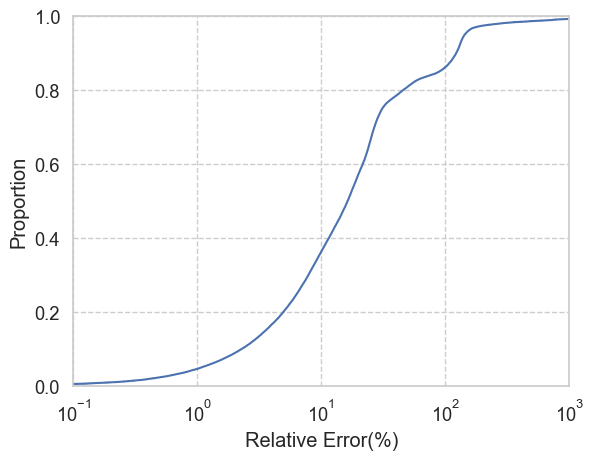

In [54]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.ecdfplot(linear_model_rel_error)

plt.xscale('log')
plt.xlim(0.1 , 1000)
plt.xlabel('Relative Error(%)')

Text(0, 0.5, 'Absolute Error (lpm)')

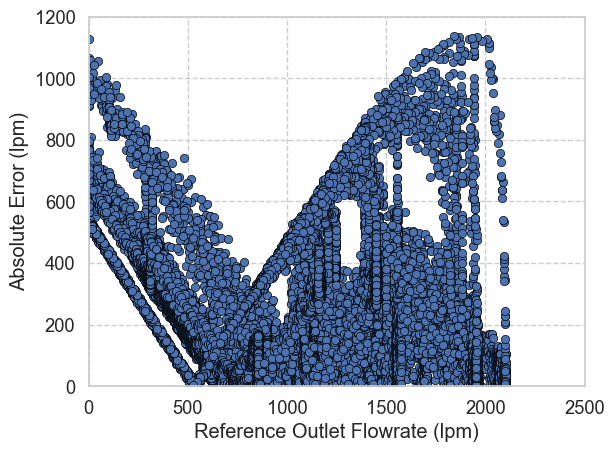

In [51]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=val_target_arr, y=linear_model_abs_error, edgecolor='black')

plt.xlim(0, 2500)
plt.xlabel('Reference Outlet Flowrate (lpm)')
plt.ylim(0, 1200)
plt.ylabel('Absolute Error (lpm)')
#plt.yscale('log')

Text(0, 0.5, 'Relative Error(%)')

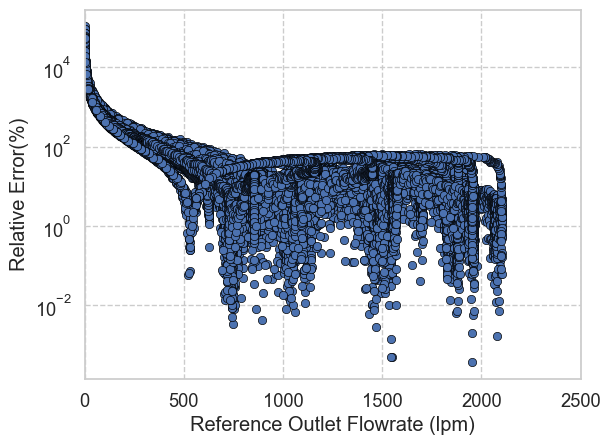

In [52]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=val_target_arr, y=linear_model_rel_error, edgecolor='black')

plt.xlim(0, 2500)
plt.xlabel('Reference Outlet Flowrate (lpm)')
plt.yscale('log')
plt.ylabel('Relative Error(%)')

In [ ]:
relative_error = abs(val_target.to_numpy()[:, 0]-pred_output[:, 0])/abs(val_target.to_numpy()[:, 0])*100

linear_result = pd.DataFrame(['linear']*len(pred_output), columns=['model_type'])
linear_result = pd.concat([linear_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(val_target.to_numpy()-pred_output, columns=['absolute_error(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, val_target], axis=1)
linear_result.reset_index(drop=True, inplace=True)

model_result = pd.DataFrame()
model_result = pd.concat([model_result, linear_result], axis=0)

In [56]:
leaves = 32
lr = 0.001
n_estimators = 5000
boosting_type = 'gbdt'
max_bin = 30

In [92]:
lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=leaves,
                              force_col_wise=True, verbose=1, n_jobs=-1)

In [93]:
lgb_model.fit(X=train_feature, y=train_target, eval_set=(val_feature, val_target), eval_metric='L2', 
              callbacks=[lgb.early_stopping(stopping_rounds=10000, min_delta=0.01), lgb.log_evaluation(period=100)])

[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 132560, number of used features: 2
[LightGBM] [Info] Start training from score 999.994014
Training until validation scores don't improve for 10000 rounds
[100]	valid_0's l2: 206669
[200]	valid_0's l2: 175675
[300]	valid_0's l2: 150288
[400]	valid_0's l2: 129454
[500]	valid_0's l2: 112362
[600]	valid_0's l2: 98354.6
[700]	valid_0's l2: 86866.2
[800]	valid_0's l2: 77452.6
[900]	valid_0's l2: 69700.5
[1000]	valid_0's l2: 63317.6
[1100]	valid_0's l2: 58069.3
[1200]	valid_0's l2: 53751.5
[1300]	valid_0's l2: 50188.1
[1400]	valid_0's l2: 47242.4
[1500]	valid_0's l2: 44811.1
[1600]	valid_0's l2: 42788.7
[1700]	valid_0's l2: 41104.2
[1800]	valid_0's l2: 39710
[1900]	valid_0's l2: 38570.3
[2000]	valid_0's l2: 37618.7
[2100]	valid_0's l2: 36825.8
[2200]	valid_0's l2: 36178.2
[2300]	valid_0's l2: 35639.8
[2400]	valid_0's l2: 35195.4
[2500]	valid_0's l2: 34840.1
[2600]	valid_0's l2: 34507.7
[2700]	valid_0's 

LGBMRegressor(force_col_wise=True, learning_rate=0.001, n_estimators=5000,
              n_jobs=-1, num_leaves=32, verbose=1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

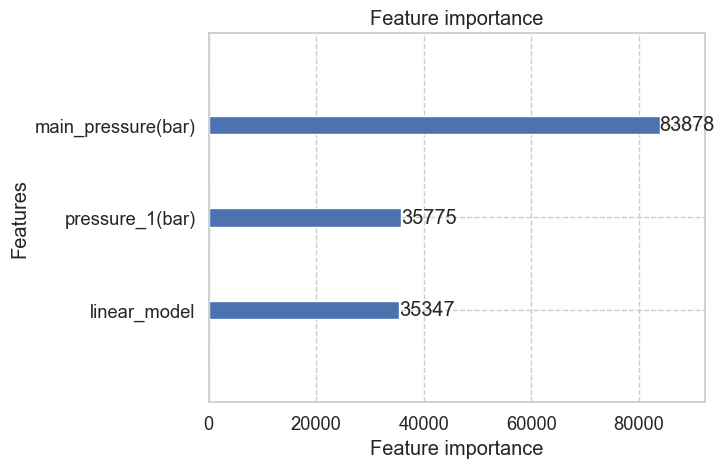

In [85]:
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
lgb.plot_importance(lgb_model, max_num_features=5)

In [87]:
lgb_model_pred = lgb_model.predict(val_feature, num_iteration=lgb_model._best_iteration)

In [88]:
lgb_model_abs_error = np.abs(val_target_arr - lgb_model_pred)
lgb_model_rel_error = lgb_model_abs_error/val_target_arr*100

In [89]:
print(r2_score(val_target, lgb_model_pred), mean_absolute_error(val_target, lgb_model_pred), mean_absolute_percentage_error(val_target, lgb_model_pred))

0.8674823571909269 117.24381831684808 1.0270293144558407


Text(0, 0.5, 'Predicted Outlet Flowrate (lpm)')

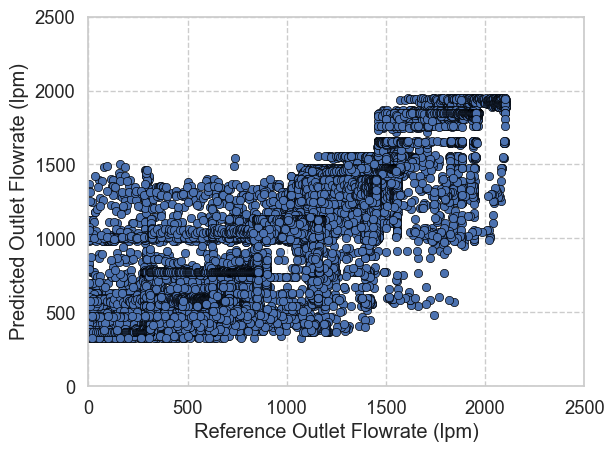

In [91]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=val_target_arr, y=lgb_model_pred, edgecolor='black')

plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.xlabel('Reference Outlet Flowrate (lpm)')
plt.ylabel('Predicted Outlet Flowrate (lpm)')